# Import Library 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize

# SenticNet for Emotion Features
from senticnet.senticnet import SenticNet

# Deep Learning
from gensim.models import FastText
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, make_scorer,roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score


# Load Data

In [ ]:
file_path = r"..\Pre_Hate_Dataset\UnseenData_ForTestSetUsed.csv"
data = pd.read_csv(file_path)
X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

# Hate Text (text for get hate speech feature)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Undersampling:
undersampler = RandomUnderSampler(random_state=42)
dummy_indices = np.arange(len(Y)).reshape(-1, 1)
train_indices_resampled, Y_resampled = undersampler.fit_resample(dummy_indices, Y)
X_resampled = X_pad[train_indices_resampled.flatten()]

# Apply the same indices to original text for SenticNet feature extraction
X_senticnet_resampled = [X[i] for i in train_indices_resampled.flatten()]

# SenticNet Feature Extraction
def extract_sentic_features(text, tokenizer, max_length):
    sn = SenticNet()
    num_sentic_features = 24  # 24-dimensional features provided by SenticNet
    sentic_matrix = np.zeros((max_length, num_sentic_features), dtype=np.float32)

    tokens = word_tokenize(text)
    token_indices = tokenizer.texts_to_sequences([tokens])[0]  # Convert to index
    
    for i, token_idx in enumerate(token_indices[:max_length]):
        word = tokenizer.index_word.get(token_idx, '')
        try:
            # Query the sentiment features of word in SenticNet
            sentic_values = [float(sn.concept(word)[j]) for j in range(num_sentic_features)]
            sentic_matrix[i] = sentic_values
        except KeyError:
            pass  # If SenticNet does not have the feature of this word, write 0
    return sentic_matrix

def batch_extract_sentic(texts, tokenizer, max_length):
    sentic_features = np.array([extract_sentic_features(text, tokenizer, max_length) for text in texts])
    return sentic_features.astype(np.float32)

x_sentic = batch_extract_sentic(X_senticnet_resampled, tokenizer, max_len)

# ------------------------------------------------------------------------------------------------------------------------
print("\n=== Word Embedding Representation ===")
print("X_resampled shape:", X_resampled.shape)
print("Y_resampled shape:", Y_resampled.shape)
print("\n=== SenticNet Representation ===")
print("x_sentic shape:", x_sentic.shape)
print("Y_resampled shape:", Y_resampled.shape)
# ------------------------------------------------------------------------------------------------------------------------



=== Word Embedding Representation ===
X_resampled shape: (37582, 100)
Y_resampled shape: (37582,)

=== SenticNet Representation ===
x_sentic shape: (37582, 100, 24)
Y_resampled shape: (37582,)


C:\Users\Asus\AppData\Local\Temp\ipykernel_27480\3640106136.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Emotion', y='Count', data=emotion_df, palette='coolwarm')


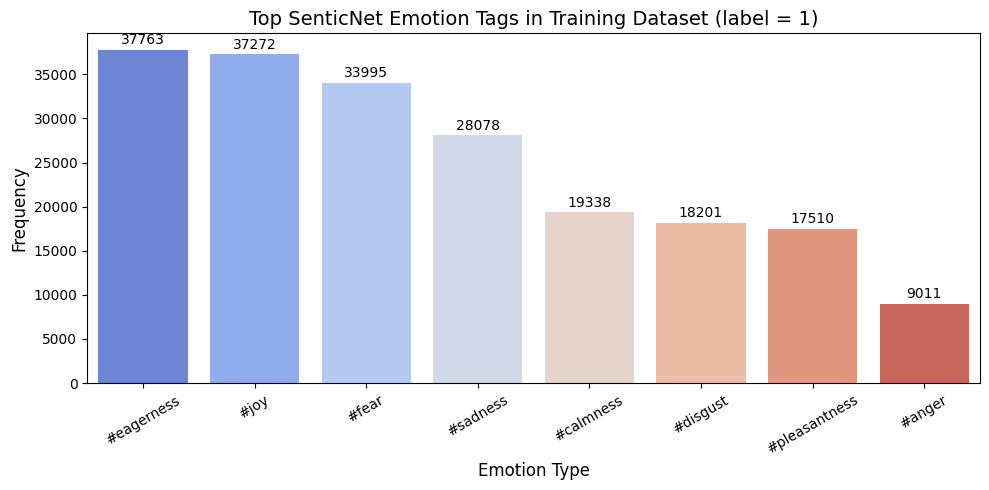

In [ ]:
# Load unseen dataset
file_path = r"..\Pre_Hate_Dataset\UnseenData_ForTestSetUsed.csv"
data = pd.read_csv(file_path)

# Filter label
hate_data = data[data['label'] == 1]
X = hate_data['text'].astype(str).values  

# Initialize SenticNet
sn = SenticNet()
emotion_count = Counter()

for text in X:
    tokens = word_tokenize(text.lower())
    for word in tokens:
        try:
            moodtags = sn.moodtags(word)
            for mood in moodtags:
                emotion_count[mood] += 1
        except KeyError:
            continue

# Convert to DataFrame
emotion_df = pd.DataFrame.from_dict(emotion_count, orient='index', columns=['Count']).reset_index()
emotion_df.columns = ['Emotion', 'Count']
emotion_df = emotion_df.sort_values(by='Count', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Emotion', y='Count', data=emotion_df, palette='coolwarm')

# Add count labels on top of bars
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', fontsize=10, padding=2)

plt.title("Top SenticNet Emotion Tags in Training Dataset (label = 1)", fontsize=14)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Emotion Type", fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
print(emotion_df)
print(f"Total unique moodtags found: {emotion_df.shape[0]}")

         Emotion  Count
0           #joy  40371
6     #eagerness  40070
4          #fear  36644
2       #sadness  30464
1      #calmness  21566
3  #pleasantness  19294
5       #disgust  19203
7         #anger   9156
Total unique moodtags found: 8


# Bi-LSTM_SenticNet Model

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

@register_keras_serializable(package="CustomLoss")
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.55): 
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
    alpha_factor = K.ones_like(y_true) * alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1 - pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Saved Model Hate/EmoHate/4_BiLSTM_FastText_SenticNet_FocalLoss_Model.keras",
    custom_objects={'focal_loss': focal_loss}
)

test_loss, test_accuracy = model.evaluate(
    [X_resampled, x_sentic],
    Y_resampled,
    verbose=1
)

y_pred_prob = model.predict([X_resampled, x_sentic])
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Test Accuracy: {test_accuracy:.4f}")
print(f"📌 Test Loss: {test_loss:.4f}")

f1_weighted = f1_score(Y_resampled, y_pred, average='weighted')
print(f"📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_resampled, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_resampled, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_resampled, y_pred, average='binary')
print(f"📌 Precision: {precision:.4f}")

recall = recall_score(Y_resampled, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_resampled, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"📌 Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_resampled, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_resampled, y_pred))


1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.4376 - loss: 0.1254
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step

📌 Test Accuracy: 0.4853
📌 Test Loss: 0.1339
📌 Weighted F1 Score: 0.4811
📌 Micro F1 Score: 0.4853
📌 Macro F1 Score: 0.4811
📌 Precision: 0.4875
📌 Recall: 0.5743
📌 Test ROC AUC: 0.4782

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.40      0.43     18791
           1       0.49      0.57      0.53     18791

    accuracy                           0.49     37582
   macro avg       0.48      0.49      0.48     37582
weighted avg       0.48      0.49      0.48     37582


📌 Confusion Matrix:
[[ 7446 11345]
 [ 8000 10791]]


# Bi-GRU

In [ ]:
file_path = r"..\Pre_Hate_Dataset\UnseenData_ForTestSetUsed.csv"
df = pd.read_csv(file_path)

X = df['text'].astype(str).values  
Y = df['label'].values  

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

max_words = 20000  
max_len = 100  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X) 
X_seq = tokenizer.texts_to_sequences(X) 
X_padding = pad_sequences(X_seq, maxlen=max_len) 

print("All test data")
print("X_padding shape:", X_padding.shape)
print("Y shape:", Y.shape)
print("Class distribution:", Counter(Y))


All test data
X_padding shape: (40638, 100)
Y shape: (40638,)
Class distribution: Counter({1: 21847, 0: 18791})


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

@register_keras_serializable(package="CustomLoss")
def focal_loss_1(y_true, y_pred, gamma=2.0, alpha=0.53):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
    
    alpha_factor = K.ones_like(y_true) * alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)

    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1 - pt), gamma) 
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Saved Model Hate/GRU/6_GRU_Hate_FineTuning_Model_1.keras",
    custom_objects={'focal_loss_1': focal_loss_1}
)

file_path = r"..\Pre_Hate_Dataset\UnseenData_ForTestSetUsed.csv"
df = pd.read_csv(file_path)

X = df['text'].astype(str).values  
Y = df['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padding = pad_sequences(X_seq, maxlen=max_len)

test_loss, test_accuracy = model.evaluate(X_padding, Y, verbose=1)
y_pred_prob = model.predict(X_padding)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y, y_pred))


1270/1270 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.4827 - loss: 0.1318
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step

📌 Test Accuracy: 0.4753

📌 Weighted F1 Score: 0.4759
📌 Micro F1 Score: 0.4753
📌 Macro F1 Score: 0.4737

📌 Precision: 0.5125
📌 Recall: 0.4921

📌Test ROC AUC: 0.4647

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.46      0.45     18791
           1       0.51      0.49      0.50     21847

    accuracy                           0.48     40638
   macro avg       0.47      0.47      0.47     40638
weighted avg       0.48      0.48      0.48     40638


📌 Confusion Matrix:
[[ 8562 10229]
 [11095 10752]]



📌 ROC AUC: 0.4676


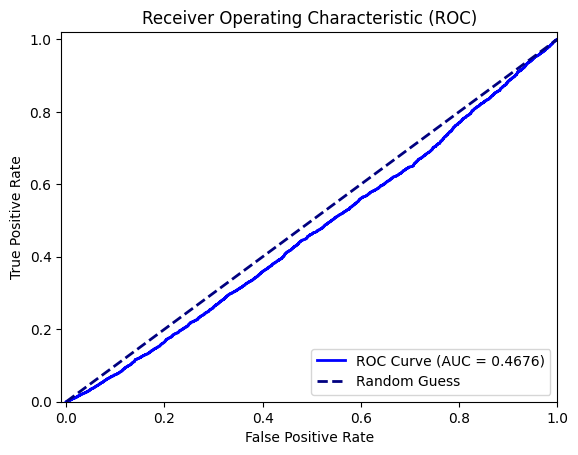

In [ ]:
fpr, tpr, thresholds = roc_curve(Y, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



📌 Precision-Recall AUC: 0.5097


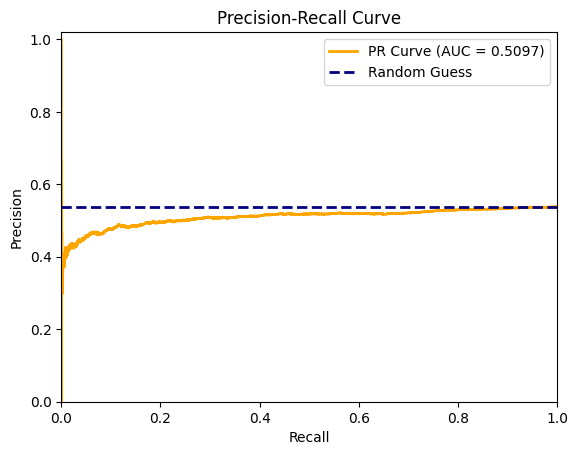

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y, y_pred_prob)
pr_auc = average_precision_score(Y, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y) / len(Y)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()
